The goal of the report which based on this analysis was: Are individuals ascribed systematically higher scores based on their racial profiles and thus leading to a racial bias in the SSL system? 

## Loading libraries and the dataset

In [ ]:
# Import the SSL Score data
!pip install pandas
!pip install sodapy

import pandas as pd
from sodapy import Socrata

client = Socrata("data.cityofchicago.org", None)

results = client.get("4aki-r3np", limit=400000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
!pip install numpy
import numpy as np
!pip install researchpy
import researchpy as rp
!pip install scipy.stats
import scipy.stats as stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ERROR: Could not find a version that satisfies the requirement scipy.stats (from versions: none)
ERROR: No matching distribution found for scipy.stats


In [ ]:
!pip install matplotlib

In [ ]:
# Getting Cases violent gun-related crimes
client = Socrata("data.cityofchicago.org", None)

results3 = client.get("gumc-mgzr", limit=400000)
df_shooting = pd.DataFrame.from_records(results3)

## Dataset cleaning

### Cleaning the predictive policing dataset (df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398684 entries, 0 to 398683
Data columns (total 53 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   ssl_score                                 398684 non-null  object
 1   predictor_rat_age_at_latest_arrest        398582 non-null  object
 2   predictor_rat_victim_shooting_incidents   398684 non-null  object
 3   predictor_rat_victim_battery_or_assault   398684 non-null  object
 4   predictor_rat_arrests_violent_offenses    398684 non-null  object
 5   predictor_rat_gang_affiliation            398684 non-null  object
 6   predictor_rat_narcotic_arrests            398684 non-null  object
 7   predictor_rat_trend_in_criminal_activity  398684 non-null  object
 8   predictor_rat_uuw_arrests                 398684 non-null  object
 9   sex_code_cd                               398684 non-null  object
 10  race_code_cd                    

In [ ]:
# Dropping some variables, because they are duplicates of others according to the Dataset description of the City of Chicago.
df.drop(['heat_score','raw_heat_score'], inplace=True, axis=1)

In [ ]:
# Convert all the 8 variables used for the calculation of the SSL score into numerical (the age variable needs to be recoded first for this)
# recoding the age variable to make it numerical (its initial form is e.g. "20-30" or "50-60")
def my_recode(age):
    if age == "less than 20":
        return 0
    elif age == "20-30":
        return 1
    elif age == "30-40":
        return 2
    elif age == "40-50":
        return 3
    elif age == "50-60":
        return 4
    elif age == "60-70":
        return 5
    elif age == "70-80":
        return 6

In [ ]:
df['age_recoded'] = df['predictor_rat_age_at_latest_arrest'].apply(my_recode)

age_recoded_reloc = df.pop("age_recoded")
df.insert(2, "age_recoded", age_recoded_reloc)

df.head()

,ssl_score,predictor_rat_age_at_latest_arrest,age_recoded,predictor_rat_victim_shooting_incidents,predictor_rat_victim_battery_or_assault,predictor_rat_arrests_violent_offenses,predictor_rat_gang_affiliation,predictor_rat_narcotic_arrests,predictor_rat_trend_in_criminal_activity,predictor_rat_uuw_arrests,sex_code_cd,race_code_cd,weapon_i,drug_i,age_group,age_to,latest_date,latest_dist,latest_dist_res,cpd_arrest_i,age_curr,raw_ssl_score,status_i,pre_raw_heat_score,community_area,majority_dist,dlst,census_tract,ssl_last_ptv_date,narcotics_arr_cnt,latest_narcotic_arr_date,domestic_arr_cnt,latest_domestic_arr_date,idoc_res_city,idoc_res_state_code,idoc_res_zip_code,weapons_arr_cnt,latest_weapon_arr_date,parolee_i,trap_flags,trap_status,stop_order_no,ssl_flags,idoc_cpd_dist,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,306,20-30,1.0,0,0,0,0,0,-0.3,0,M,WWH,N,N,20-30,20-30,2012,31,31,N,20-30,0.0911,Y,9110,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,352,20-30,1.0,0,1,0,0,0,0,0,M,BLK,N,N,20-30,20-30,2015,31,31,N,20-30,0.09949,Y,9949,,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,349,20-30,1.0,0,0,2,0,2,0,0,M,BLK,N,N,20-30,20-30,2016,31,31,N,20-30,0.09908,Y,9908,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,344,20-30,1.0,0,0,3,0,0,-0.3,0,M,WHI,N,N,20-30,20-30,2014,31,31,N,20-30,0.0981,Y,9810,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,343,20-30,1.0,0,0,1,0,0,0.4,0,M,BLK,N,N,20-30,20-30,2015,31,31,N,20-30,0.09794,Y,9794,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert data types in df
cols = df.columns
for c in cols:
    try:
        df[c] = pd.to_numeric(df[c])
    except:
        pass

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398684 entries, 0 to 398683
Data columns (total 52 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   ssl_score                                 398684 non-null  int64  
 1   predictor_rat_age_at_latest_arrest        398582 non-null  object 
 2   age_recoded                               398582 non-null  float64
 3   predictor_rat_victim_shooting_incidents   398684 non-null  int64  
 4   predictor_rat_victim_battery_or_assault   398684 non-null  int64  
 5   predictor_rat_arrests_violent_offenses    398684 non-null  int64  
 6   predictor_rat_gang_affiliation            398684 non-null  int64  
 7   predictor_rat_narcotic_arrests            398684 non-null  int64  
 8   predictor_rat_trend_in_criminal_activity  398684 non-null  float64
 9   predictor_rat_uuw_arrests                 398684 non-null  int64  
 10  sex_code_cd         

### Cleaning the actual crime dataset (df_shooting)

In [ ]:
# Convert data types of df_shooting
cols = df_shooting.columns
for c in cols:
    try:
        df_shooting[c] = pd.to_numeric(df_shooting[c])
    except:
        pass

df_shooting["date"] = pd.to_datetime(df_shooting["date"])

df_shooting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51217 entries, 0 to 51216
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   case_number                   51217 non-null  object        
 1   date                          51217 non-null  datetime64[ns]
 2   victimization_primary         51217 non-null  object        
 3   incident_primary              51217 non-null  object        
 4   gunshot_injury_i              51217 non-null  object        
 5   unique_id                     51217 non-null  object        
 6   street_outreach_organization  51217 non-null  object        
 7   age                           51217 non-null  object        
 8   sex                           51217 non-null  object        
 9   race                          51217 non-null  object        
 10  victimization_iucr_cd         51217 non-null  object        
 11  incident_iucr_cd            

In [ ]:
# Filter out District 31, because it is not part of Chicago
df_shooting = df_shooting[(df_shooting["district"]!= 31)]

# Descriptive analysis

### Approximate weights of the predictors in the algorithm

In [ ]:
# We run a linear regression for the 8 variables accounted for in the algorithm

import statsmodels.formula.api as smf
import numpy as np

In [ ]:
import statsmodels.api as sm

In [ ]:
#OLS regression in a classic way does not work because there are missing values -> we try a different method that should be able to filter them 
#the coefficients show the impact of a one-unit change in the variable on the SSL score
lm =  smf.ols('ssl_score ~ age_recoded + predictor_rat_victim_shooting_incidents + predictor_rat_victim_battery_or_assault + predictor_rat_arrests_violent_offenses + predictor_rat_gang_affiliation + predictor_rat_narcotic_arrests + predictor_rat_trend_in_criminal_activity + predictor_rat_uuw_arrests', data=df)
lm_res = lm.fit()
lm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              ssl_score   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 9.430e+05
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        17:42:50   Log-Likelihood:            -1.5869e+06
No. Observations:              398582   AIC:                         3.174e+06
Df Residuals:                  398573   BIC:                         3.174e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                  344.1459      0.037   9187.655      0.000     344.073     344.219
age_recoded                                -40.8615      0.016  -2512.024      0.000     -40.893     -40.830
predictor_rat_victim_shooting_incidents     16.6967      0.154    108.266      0.000      16.394      16.999
predictor_rat_victim_battery_or_assault     33.5872      0.111    303.205      0.000      33.370      33.804
predictor_rat_arrests_violent_offenses      14.8839      0.062    239.203      0.000      14.762      15.006
predictor_rat_gang_affiliation               4.1384      0.062     66.795      0.000       4.017       4.260
predictor_rat_narcotic_arrests               5.2459      0.026    199.984      0.000       5.195       5.297
predictor_rat_trend_in_criminal_activity    14.1905      0.051    277.893      0.000      14.090      14.291
predictor_rat_uuw_arrests                   11.6623      0.127     91.562      0.000      11.413      11.912
==============================================================================
Omnibus:                    28792.782   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79364.326
Skew:                           0.404   Prob(JB):                         0.00
Kurtosis:                       5.031   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


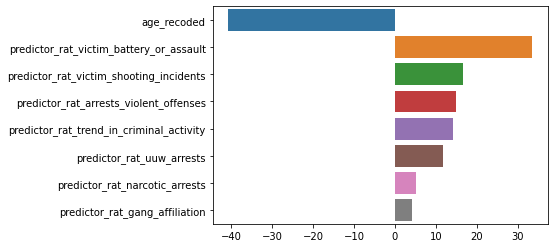

In [ ]:
coeff = lm_res.params
coeff = coeff.drop("Intercept")
coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
sns.barplot(coeff.values, coeff.index, orient='h');

### Descriptive analysis

In [ ]:
df.describe(include="all")

,ssl_score,predictor_rat_age_at_latest_arrest,age_recoded,predictor_rat_victim_shooting_incidents,predictor_rat_victim_battery_or_assault,predictor_rat_arrests_violent_offenses,predictor_rat_gang_affiliation,predictor_rat_narcotic_arrests,predictor_rat_trend_in_criminal_activity,predictor_rat_uuw_arrests,sex_code_cd,race_code_cd,weapon_i,drug_i,age_group,age_to,latest_date,latest_dist,latest_dist_res,cpd_arrest_i,age_curr,raw_ssl_score,status_i,pre_raw_heat_score,community_area,majority_dist,dlst,census_tract,ssl_last_ptv_date,narcotics_arr_cnt,latest_narcotic_arr_date,domestic_arr_cnt,latest_domestic_arr_date,idoc_res_city,idoc_res_state_code,idoc_res_zip_code,weapons_arr_cnt,latest_weapon_arr_date,parolee_i,trap_flags,trap_status,stop_order_no,ssl_flags,idoc_cpd_dist,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
count,398684.000000,398582,398582.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684.000000,398684,398684,398684,398684,398531,398531,398684.000000,398684.000000,398684.000000,398684,398443,398684.000000,398684,398684.000000,398684,252670.000000,58960,2.277630e+05,14194.000000,92807.000000,92807.000000,68126.000000,68126.000000,58943,58945,5.826700e+04,19147.000000,19147.000000,13084,105.000000,3118.00000,1.657000e+03,448.000000,11222.000000,224235.000000,224235.000000,224235,222602.000000,222602.000000,224235.000000,224223.000000,222602.000000
unique,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,7,2,2,7,7,NaN,NaN,NaN,2,7,NaN,1,NaN,78,NaN,71,NaN,NaN,NaN,NaN,NaN,NaN,800,41,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801,NaN,NaN,NaN,NaN,NaN
top,NaN,20-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,BLK,N,N,20-30,20-30,NaN,NaN,NaN,Y,20-30,NaN,Y,NaN,,NaN,IL,NaN,NaN,NaN,NaN,NaN,NaN,CHICAGO,IL,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'latitude': '41.8810264912494', 'longitude': ...",NaN,NaN,NaN,NaN,NaN
freq,NaN,140357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,302320,207842,379537,305877,140587,140587,NaN,NaN,NaN,210482,142720,NaN,398684,NaN,174373,NaN,57133,NaN,NaN,NaN,NaN,NaN,NaN,47353,58046,NaN,NaN,NaN,13084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160,NaN,NaN,NaN,NaN,NaN
mean,279.839743,NaN,1.703878,0.020227,0.035916,0.114988,0.162903,0.335752,-0.049534,0.033297,NaN,NaN,NaN,NaN,NaN,NaN,2014.201440,20.250123,20.421482,NaN,NaN,0.086283,NaN,8628.320038,NaN,11.485724,NaN,1.676766e+10,2012.208398,2.059047,2012.274333,1.474488,2012.214837,NaN,NaN,6.969055e+06,1.206299,2011.600982,NaN,11.904762,3.20077,2.999831e+08,12.026786,10.923989,41.840128,-87.675659,NaN,32.004385,38.509717,19067.161081,381.673843,25.140659
std,57.996284,NaN,1.282374,0.152919,0.210601,0.405583,0.369278,0.837828,0.404900,0.193237,NaN,NaN,NaN,NaN,NaN,NaN,1.379747,11.079767,11.032506,NaN,NaN,0.010671,NaN,1067.125012,NaN,7.091204,NaN,2.103225e+09,3.146548,1.645999,2.892368,1.009570,2.906680,NaN,NaN,6.425884e+07,0.494254,2.896807,NaN,7.225122,0.40064,1.321526e+04,7.176222,6.649782,0.083300,0.058921,NaN,18.980330,19.129092,5770.307236,235.215117,14.588777
min,10.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.200000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2006.000000,1.000000,1.000000,NaN,NaN,0.036690,NaN,3669.000000,NaN,1.000000,NaN,0.000000e+00,1982.000000,1.000000,2006.000000,1.000000,2006.000000,NaN,NaN,0.000000e+00,1.000000,2006.000000,NaN,1.000000,3.00000,2.999066e+08,1.000000,1.000000,41.650220,-87.904488,NaN,1.000000,1.000000,4299.000000,1.000000,1.000000
25%,242.000000,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.300000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,9.000000,9.000000,NaN,NaN,0.079260,NaN,7926.000000,NaN,6.000000,NaN,1.703125e+10,2010.000000,1.000000,2010.000000,1.000000,2010.000000,NaN,NaN,6.060800e+04,1.000000,2009.000000,NaN,6.000000,3.00000,2.999819e+08,6.000000,6.000000,41.769259,-87.721540,NaN,19.000000,26.000000,21184.000000,174.000000,13.000000
50%,289.000000,NaN,1.000000,0

In [ ]:
# Recoding variables for clarity. Merging black and white Hispanics for simplicity.
df_plot = df

df_plot["race_code_cd"].replace(to_replace=dict(BLK="Black", WHI="White", WWH="Hispanic", API="Asian", WBH="Hispanic", I="AmIndian", U= "Unknown"), inplace=True)

df_plot["race_code_cd"].unique()

array(['Hispanic', 'Black', 'White', 'Asian', 'Unknown', 'AmIndian'],
      dtype=object)

<BarContainer object of 473 artists>

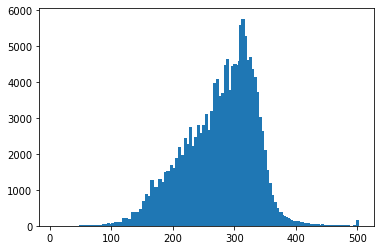

In [ ]:
#distribution of SSL score in the list 
decile_score_count=df['ssl_score'].value_counts()
plt.bar(decile_score_count.index,decile_score_count.values, width=5, )
#plt.bar(decile_score_count.index,decile_score_count.values, width=5, ).savefig("hist_plot.png")


Marc : we must add labels to this graph.

In [ ]:
# assess how many subjects per race there are in the dataset
# results showing that there are very few Asians, Am. Indians, and Unknown subjects
# as a result, we focus only on Whites, Blacks, and Hispanics in the rest of our analysis
df_plot["race_code_cd"].value_counts()

Black       207842
Hispanic    101684
White        82366
Asian         4617
Unknown       1899
AmIndian       276
Name: race_code_cd, dtype: int64

In [ ]:
#visualise the difference in SSL score distribution between white and black people in various ways

df_blk = df_plot["race_code_cd"] == 'Black'
df_whi = df_plot["race_code_cd"] == 'White'
df_hisp = df_plot["race_code_cd"] == "Hispanic"
df_race = df_blk | df_whi | df_hisp
df_plot[df_race]

,ssl_score,predictor_rat_age_at_latest_arrest,age_recoded,predictor_rat_victim_shooting_incidents,predictor_rat_victim_battery_or_assault,predictor_rat_arrests_violent_offenses,predictor_rat_gang_affiliation,predictor_rat_narcotic_arrests,predictor_rat_trend_in_criminal_activity,predictor_rat_uuw_arrests,sex_code_cd,race_code_cd,weapon_i,drug_i,age_group,age_to,latest_date,latest_dist,latest_dist_res,cpd_arrest_i,age_curr,raw_ssl_score,status_i,pre_raw_heat_score,community_area,majority_dist,dlst,census_tract,ssl_last_ptv_date,narcotics_arr_cnt,latest_narcotic_arr_date,domestic_arr_cnt,latest_domestic_arr_date,idoc_res_city,idoc_res_state_code,idoc_res_zip_code,weapons_arr_cnt,latest_weapon_arr_date,parolee_i,trap_flags,trap_status,stop_order_no,ssl_flags,idoc_cpd_dist,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,306,20-30,1.0,0,0,0,0,0,-0.3,0,M,Hispanic,N,N,20-30,20-30,2012,31,31,N,20-30,0.09110,Y,9110,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,352,20-30,1.0,0,1,0,0,0,0.0,0,M,Black,N,N,20-30,20-30,2015,31,31,N,20-30,0.09949,Y,9949,,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,349,20-30,1.0,0,0,2,0,2,0.0,0,M,Black,N,N,20-30,20-30,2016,31,31,N,20-30,0.09908,Y,9908,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,344,20-30,1.0,0,0,3,0,0,-0.3,0,M,White,N,N,20-30,20-30,2014,31,31,N,20-30,0.09810,Y,9810,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,343,20-30,1.0,0,0,1,0,0,0.4,0,M,Black,N,N,20-30,20-30,2015,31,31,N,20-30,0.09794,Y,9794,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398679,183,50-60,4.0,0,0,0,0,0,0.3,0,F,Black,N,N,50-60,50-60,2015,9,9,Y,50-60,0.06845,Y,6845,NEW CITY,9.0,NaN,1.703184e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.801657,-87.640476,"{'latitude': '41.8016568337619', 'longitude': ...",37.0,59.0,14924.0,84.0,9.0
398680,213,60-70,5.0,0,0,2,0,0,2.2,0,M,Black,N,N,60-70,60-70,2016,16,12,Y,60-70,0.07396,Y,7396,OHARE,1.0,IL,1.703198e+10,NaN,NaN,NaN,NaN,NaN,TINLEY PARK,IL,60477.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.980265,-87.903894,"{'latitude': '41.9802652602173', 'longitude': ...",38.0,75.0,16197.0,668.0,29.0
398681,277,30-40,2.0,0,0,0,0,0,-0.3,0,M,Hispanic,N,N,20-30,20-30,2007,9,9,Y,30-40,0.08569,Y,8569,NEW CITY,9.0,IL,1.703184e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.801657,-87.640476,"{'latitude': '41.8016568337619', 'longitude': ...",37.0,59.0,14924.0,84.0,9.0
398682,220,40-50,3.0,0,0,0,0,0,-0.3,0,F,White,N,N,40-50,40-50,2013,8,31,Y,40-50,0.07535,Y,7535,GARFIELD RIDGE,8.0,NaN,1.703198e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.785981,-87.750900,"{'latitude': '41.78598134777', 'longitude': '-...",7.0,53.0,22268.0,86.0,6.0


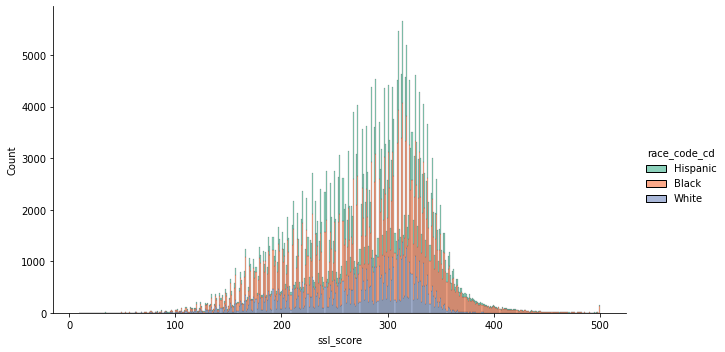

In [ ]:
sns.displot(data=df_plot[df_race], x='ssl_score', discrete=True,
            kind='hist', hue = 'race_code_cd',multiple='stack', 
            height=5, aspect=1.8, palette= "Set2")

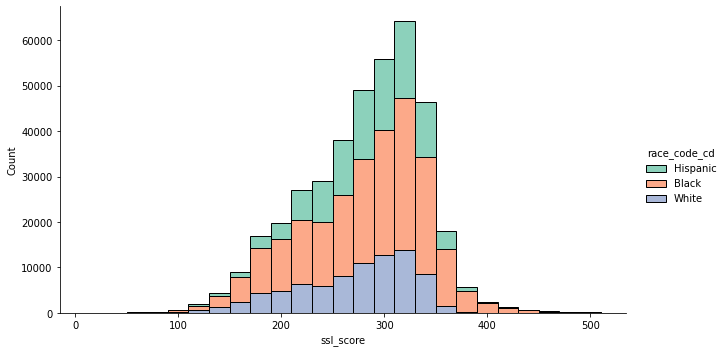

In [ ]:
sns.displot(data=df_plot[df_race], x='ssl_score',
            kind='hist', hue = 'race_code_cd',multiple='stack', 
            height=5, aspect=1.8, binwidth=20, palette = "Set2")

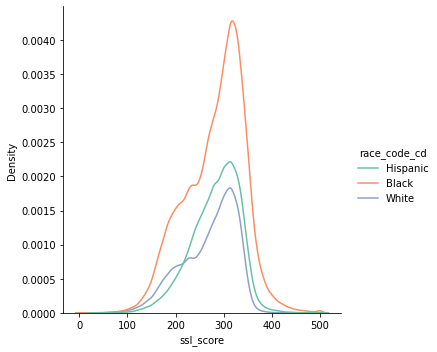

In [ ]:
sns.displot(data=df_plot[df_race], x='ssl_score',
            kind='kde', hue = 'race_code_cd', palette = "Set2")

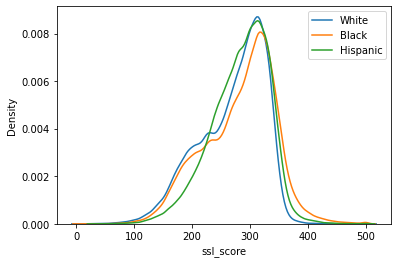

In [ ]:
# adjusting the KDE plot to scale
fig, ax = plt.subplots()
sns.kdeplot(df_plot[df_whi]['ssl_score'], ax=ax, label="White")
sns.kdeplot(df_plot[df_blk]['ssl_score'], ax=ax, label="Black")
sns.kdeplot(df_plot[df_hisp]['ssl_score'], ax=ax, label="Hispanic")
plt.legend()

In [ ]:
df['ssl_score'].mean()

279.83974275365955

In [ ]:
df["ssl_score"].median()

289.0

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

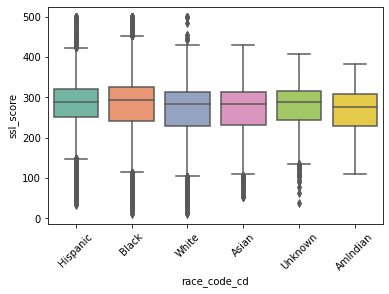

In [ ]:
ax = sns.boxplot(x="race_code_cd", y="ssl_score", data=df_plot, palette = "Set2")
plt.xticks(rotation=45)

In [ ]:
df_plot[(df_plot["race_code_cd"]=="White")]["ssl_score"].mean()

269.7238423621397

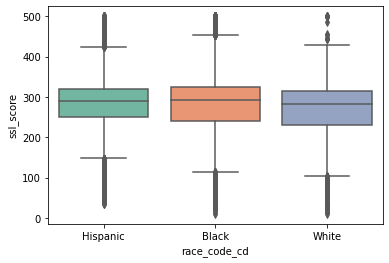

In [ ]:
#visualise only the difference between white and black people and then run t-test to see whether the difference is significant 
#tbh I think that running the t-test like this is wrong, need to check
ax = sns.boxplot(x="race_code_cd", y="ssl_score", data=df_plot[df_race], palette ="Set2")

# Racial bias using districts as proxy

Here we compute the average risk score per police district (based on the majority district variable, most contacts of the individual with police) and rank the district according to the average risk score. We will then compare the ranking with actual crime rates per police district.

### Ranking the districts with the predictive policing dataset (df)

In [ ]:
df.head()

,ssl_score,predictor_rat_age_at_latest_arrest,age_recoded,predictor_rat_victim_shooting_incidents,predictor_rat_victim_battery_or_assault,predictor_rat_arrests_violent_offenses,predictor_rat_gang_affiliation,predictor_rat_narcotic_arrests,predictor_rat_trend_in_criminal_activity,predictor_rat_uuw_arrests,sex_code_cd,race_code_cd,weapon_i,drug_i,age_group,age_to,latest_date,latest_dist,latest_dist_res,cpd_arrest_i,age_curr,raw_ssl_score,status_i,pre_raw_heat_score,community_area,majority_dist,dlst,census_tract,ssl_last_ptv_date,narcotics_arr_cnt,latest_narcotic_arr_date,domestic_arr_cnt,latest_domestic_arr_date,idoc_res_city,idoc_res_state_code,idoc_res_zip_code,weapons_arr_cnt,latest_weapon_arr_date,parolee_i,trap_flags,trap_status,stop_order_no,ssl_flags,idoc_cpd_dist,latitude,longitude,location,:@computed_region_rpca_8um6,:@computed_region_vrxf_vc4k,:@computed_region_6mkv_f3dw,:@computed_region_bdys_3d7i,:@computed_region_43wa_7qmu
0,306,20-30,1.0,0,0,0,0,0,-0.3,0,M,Hispanic,N,N,20-30,20-30,2012,31,31,N,20-30,0.09110,Y,9110,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,352,20-30,1.0,0,1,0,0,0,0.0,0,M,Black,N,N,20-30,20-30,2015,31,31,N,20-30,0.09949,Y,9949,,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,349,20-30,1.0,0,0,2,0,2,0.0,0,M,Black,N,N,20-30,20-30,2016,31,31,N,20-30,0.09908,Y,9908,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,344,20-30,1.0,0,0,3,0,0,-0.3,0,M,White,N,N,20-30,20-30,2014,31,31,N,20-30,0.09810,Y,9810,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,343,20-30,1.0,0,0,1,0,0,0.4,0,M,Black,N,N,20-30,20-30,2015,31,31,N,20-30,0.09794,Y,9794,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Computing the average per district and ranking the districts (and filtering out district 31 which does not exist)
mean_ssl_by_district = df[(df["majority_dist"]!=31)]
mean_ssl_by_district = mean_ssl_by_district.groupby('majority_dist')['ssl_score'].mean().to_frame().sort_values(by=['ssl_score'], ascending=False)
mean_ssl_by_district.reset_index(inplace=True)
mean_ssl_by_district = mean_ssl_by_district.astype({"majority_dist": int})
mean_ssl_by_district = mean_ssl_by_district.rename(columns={'majority_dist': 'district'})
mean_ssl_by_district['SSL_ranking'] = (mean_ssl_by_district.index)+1
mean_ssl_by_district

,district,ssl_score,SSL_ranking
0,8,291.029038,1
1,22,288.392538,2
2,4,287.278333,3
3,17,287.003289,4
4,3,286.584177,5
5,9,286.255642,6
6,5,285.328719,7
7,7,284.902544,8
8,6,283.236968,9
9,10,283.052751,10


### Ranking the districts with the actual crimes dataset (df_shooting)

In [ ]:
# Importing demographic data about individual districts
# The Data needs to be copied into your drive
# The data can be copied from here https://docs.google.com/spreadsheets/d/1_jz3wA36bMzhKe4EAYG1BrkCd6IzcUF6/edit#gid=1738360067
from google.colab import drive
drive.mount('/content/drive')

df_demo = pd.read_excel('/content/drive/My Drive/Demographics in Chicago.xlsx')

Mounted at /content/drive


In [ ]:
# we must make the numbers integers, not floats
df_demo = df_demo.astype(int)
df_demo = df_demo.rename(columns={'Police district': 'district', "Total":"total_population"})
 
df_demo.head()

,district,total_population,Asian,Black,Hispanic,White,Other
0,1,79265,13218,15692,5869,41851,2633
1,2,98479,7409,64071,4003,19387,3607
2,3,73321,951,66275,1897,2819,1377
3,4,125376,334,78768,36700,8671,901
4,5,76472,179,70838,2599,1484,1371


In [ ]:
count_violent_by_district = df_shooting['district'].value_counts().to_frame().sort_values(by=['district'], ascending=False)
count_violent_by_district.reset_index(inplace=True)
count_violent_by_district = count_violent_by_district.rename(columns={'district': 'violent_crimes', 'index': 'district'})
count_violent_by_district

,district,violent_crimes
0,11.0,5909
1,7.0,4905
2,6.0,3679
3,10.0,3598
4,3.0,3531
5,5.0,3402
6,4.0,3300
7,15.0,3169
8,9.0,3155
9,8.0,2713


In [ ]:
#Converting the crime incidences to rates (crime incidences per 10,000 pop)
crime_join = pd.merge(count_violent_by_district, df_demo, on = "district", how ='inner')
crime_join=crime_join.assign(crimes_10k_people=(crime_join["violent_crimes"])/((crime_join["total_population"])/10000))
crime_join

,district,violent_crimes,total_population,Asian,Black,Hispanic,White,Other,crimes_10k_people
0,11.0,5909,76418,346,48484,21986,4456,1144,773.247141
1,7.0,4905,52281,92,47672,3366,595,554,938.199346
2,6.0,3679,79034,245,75499,1270,1121,898,465.495863
3,10.0,3598,107663,404,33895,67207,5543,611,334.190948
4,3.0,3531,73321,951,66275,1897,2819,1377,481.580993
5,5.0,3402,76472,179,70838,2599,1484,1371,444.868710
6,4.0,3300,125376,334,78768,36700,8671,901,263.208270
7,15.0,3169,49631,237,37327,8672,2857,2486,638.512220
8,9.0,3155,155409,31660,14675,83358,24407,1308,203.012696
9,8.0,2713,226571,3653,25276,144443,50952,2246,119.741715


In [ ]:
district_criminality = crime_join.sort_values(by=['crimes_10k_people'], ascending=False)
district_criminality = district_criminality.reset_index()
district_criminality = district_criminality.drop(columns=['index'])
district_criminality['crime_ranking'] = (district_criminality.index)+1
district_criminality

,district,violent_crimes,total_population,Asian,Black,Hispanic,White,Other,crimes_10k_people,crime_ranking
0,7.0,4905,52281,92,47672,3366,595,554,938.199346,1
1,11.0,5909,76418,346,48484,21986,4456,1144,773.247141,2
2,15.0,3169,49631,237,37327,8672,2857,2486,638.512220,3
3,3.0,3531,73321,951,66275,1897,2819,1377,481.580993,4
4,6.0,3679,79034,245,75499,1270,1121,898,465.495863,5
5,5.0,3402,76472,179,70838,2599,1484,1371,444.868710,6
6,10.0,3598,107663,404,33895,67207,5543,611,334.190948,7
7,4.0,3300,125376,334,78768,36700,8671,901,263.208270,8
8,2.0,2500,98479,7409,64071,4003,19387,3607,253.861229,9
9,9.0,3155,155409,31660,14675,83358,24407,1308,203.012696,10


### Comparing the two district rankings

In [ ]:
# We make a new column comparing the difference between the rankings for each district
# We create new columns determining the dominant race in a given district (most districts well above 50% of one race, only districts 17 strongly contestable)
rankings_join = pd.merge(district_criminality, mean_ssl_by_district, on = "district", how ='inner')
rankings_join = rankings_join[["district", "White", "Black", "Hispanic", "Asian", "crime_ranking", "SSL_ranking"]]
rankings_join = rankings_join.sort_values(by="SSL_ranking")
rankings_join = rankings_join.reset_index()
rankings_join = rankings_join.drop(columns=['index'])
rankings_join = rankings_join.assign(ranking_difference=(rankings_join["SSL_ranking"])-(rankings_join["crime_ranking"]), black_majority=np.where((rankings_join["Black"]>rankings_join["White"]) & (rankings_join["Black"]>rankings_join["Hispanic"]) & (rankings_join["Black"]>rankings_join["Asian"]), 1, 0), white_majority=np.where((rankings_join["White"]>rankings_join["Black"]) & (rankings_join["White"]>rankings_join["Hispanic"]) & (rankings_join["White"]>rankings_join["Asian"]), 1, 0), hispanic_majority=np.where((rankings_join["Hispanic"]>rankings_join["White"]) & (rankings_join["Hispanic"]>rankings_join["Black"]) & (rankings_join["Hispanic"]>rankings_join["Asian"]), 1, 0), asian_majority=np.where((rankings_join["Asian"]>rankings_join["White"]) & (rankings_join["Asian"]>rankings_join["Black"]) & (rankings_join["Asian"]>rankings_join["Hispanic"]), 1, 0))
rankings_join = rankings_join.assign(mixed_race=np.where((rankings_join["black_majority"]==0) & (rankings_join["white_majority"]==0) & (rankings_join["hispanic_majority"]==0) & (rankings_join["asian_majority"]==0), 1, 0))
rankings_join = rankings_join.drop(columns=["asian_majority", "mixed_race"])
rankings_join = rankings_join.assign(threat_level=np.where(rankings_join["crime_ranking"]<=4, "extreme", np.where(rankings_join["crime_ranking"]<=8, "high", np.where(rankings_join["crime_ranking"]<=12, "medium", np.where(rankings_join["crime_ranking"]<=16, "low", np.where(rankings_join["crime_ranking"]>16,"negligible", "null"))))))
rankings_join = rankings_join.assign(SSL_threat_level=np.where(rankings_join["SSL_ranking"]<=4, "extreme", np.where(rankings_join["SSL_ranking"]<=8, "high", np.where(rankings_join["SSL_ranking"]<=12, "medium", np.where(rankings_join["SSL_ranking"]<=16, "low", np.where(rankings_join["SSL_ranking"]>16,"negligible", "null"))))))
rankings_join = rankings_join.assign(pred_correct = np.where(rankings_join["threat_level"] == rankings_join["SSL_threat_level"],1,0))
rankings_join

,district,White,Black,Hispanic,Asian,crime_ranking,SSL_ranking,ranking_difference,black_majority,white_majority,hispanic_majority,threat_level,SSL_threat_level,pred_correct
0,8.0,50952,25276,144443,3653,15,1,-14,0,0,1,low,extreme,0
1,22.0,34082,56660,4388,655,11,2,-9,1,0,0,medium,extreme,0
2,4.0,8671,78768,36700,334,8,3,-5,1,0,0,high,extreme,0
3,17.0,57603,5147,59207,17904,18,4,-14,0,0,1,negligible,extreme,0
4,3.0,2819,66275,1897,951,4,5,1,1,0,0,extreme,high,0
5,9.0,24407,14675,83358,31660,10,6,-4,0,0,1,medium,high,0
6,5.0,1484,70838,2599,179,6,7,1,1,0,0,high,high,1
7,7.0,595,47672,3366,92,1,8,7,1,0,0,extreme,high,0
8,6.0,1121,75499,1270,245,5,9,4,1,0,0,high,medium,0
9,10.0,5543,33895,67207,404,7,10,3,0,0,1,high,medium,0


In [ ]:
# Computing Performance Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

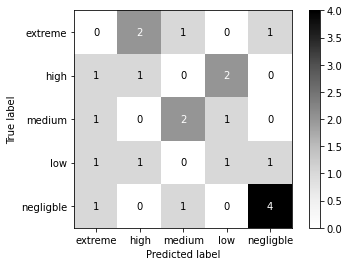

In [ ]:
# Confusion matrix comparing the actual threat level with the SSL threat level (all based on rankings of districts)
cm_overall = confusion_matrix(rankings_join["threat_level"], rankings_join["SSL_threat_level"])
display = ConfusionMatrixDisplay(cm_overall, display_labels = ["extreme", "high", "medium", "low", "negligble"])
display.plot(cmap='Greys')

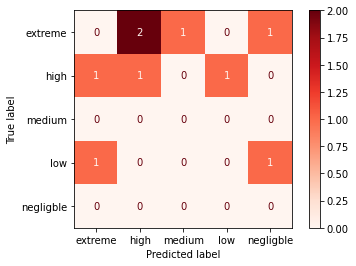

In [ ]:
black=rankings_join[(rankings_join["black_majority"]==1)]
black_confusion_matrix = confusion_matrix(black["threat_level"], black["SSL_threat_level"])

display = ConfusionMatrixDisplay(black_confusion_matrix, display_labels = ["extreme", "high", "medium", "low", "negligble"])
display.plot(cmap='Reds')

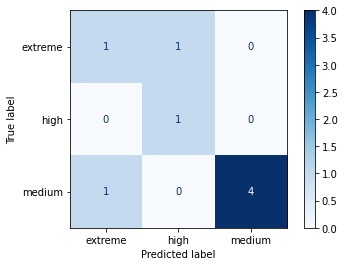

In [ ]:
white=rankings_join[(rankings_join["white_majority"]==1)]
white_confusion_matrix = confusion_matrix(white["threat_level"], white["SSL_threat_level"])

display = ConfusionMatrixDisplay(white_confusion_matrix, display_labels = ["extreme", "high", "medium", "low", "negligble"])
display.plot(cmap='Blues')

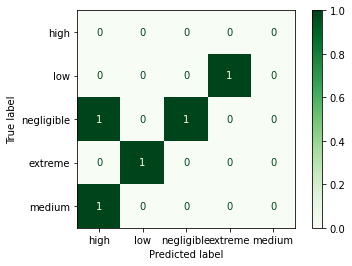

In [ ]:
hispanic=rankings_join[(rankings_join["hispanic_majority"]==1)]
hispanic_confusion_matrix = confusion_matrix(hispanic["threat_level"], hispanic["SSL_threat_level"])

display = ConfusionMatrixDisplay(hispanic_confusion_matrix, display_labels=set(
    hispanic["threat_level"].unique()).union(set(hispanic["SSL_threat_level"].unique())))
display.plot(cmap='Greens')

In [ ]:
from sklearn.metrics import accuracy_score
# Computing the accuracy (whether exactly same threat level or not)
accuracy_overall = accuracy_score(rankings_join["threat_level"], rankings_join["SSL_threat_level"], normalize = True, sample_weight = None)
accuracy_black = accuracy_score(black["threat_level"], black["SSL_threat_level"], normalize=True, sample_weight=None)
accuracy_white = accuracy_score(white["threat_level"], white["SSL_threat_level"], normalize=True, sample_weight=None)
accuracy_hispanic = accuracy_score(hispanic["threat_level"], hispanic["SSL_threat_level"], normalize=True, sample_weight=None)
print("Accuracy of SSL threat level overall: {}".format(accuracy_overall))
print("Accuracy of SSL threat level for white people: {}".format(accuracy_white))
print("Accuracy of SSL threat level for black people: {}".format(accuracy_black))
print("Accuracy of SSL threat level for hispanic people: {}".format(accuracy_hispanic))

Accuracy of SSL threat level overall: 0.36363636363636365
Accuracy of SSL threat level for white people: 0.75
Accuracy of SSL threat level for black people: 0.1111111111111111
Accuracy of SSL threat level for hispanic people: 0.2


In [ ]:
# We observe 8 predominantly white districts, 9 black, 5 hispanic
rankings_join["white_majority"].sum()

8

In [ ]:
rankings_join["black_majority"].sum()

9

In [ ]:
rankings_join["hispanic_majority"].sum()

5

In [ ]:
# We compare the mean ranking difference for predominantly black, white, and hispanic districts
# We observe systematic underestimation of the violent crime threat in black districts compared to real-world data 
# We observe systemic overestimation of the the violent crime threat in white and especially hispanic districts compared to real-world data
blk_rank=rankings_join[(rankings_join["black_majority"]==1)]["ranking_difference"].mean()
blk_rank


3.7777777777777777

In [ ]:
whi_rank=rankings_join[(rankings_join["white_majority"]==1)]["ranking_difference"].mean()
whi_rank

-0.875

In [ ]:
hisp_rank=rankings_join[(rankings_join["hispanic_majority"]==1)]["ranking_difference"].mean()
hisp_rank

-5.4

In [ ]:
print("Mean difference for white districts between predicted risk and real shooting risk:", whi_rank)
print("Mean difference for black districts between predicted risk and real shooting risk:", blk_rank)
print("Mean difference for hispanic districts between predicted risk and real shooting risk:", hisp_rank)

Mean difference for white districts between predicted risk and real shooting risk: -0.875
Mean difference for black districts between predicted risk and real shooting risk: 3.7777777777777777
Mean difference for hispanic districts between predicted risk and real shooting risk: -5.4


Running linear regressions partially confirms the findings. The results:  
    
Black districts: 6.77 ranking places underestimated.   
White districts: -0.39 ranking places overestimated.  
Hispanic districts: -8.8 ranking places overestimated.  
  
Results are statistically significant for Black districts (p=0.037) but not statistically significant for Hispanic districts (p=0.054) and for White districts (p=0.677).  
  
**We can conclude with some certainty that the risk for White districts is accurately predicted while the risk for Black districts is significantly underestimated. Risk for Hispanic districts is probably overestimated but we cannot definitively rule out the null hypothesis that the results occured by chance.**

In [ ]:
# Running linear regression models for ranking difference dependent on race majority in a districts
import statsmodels.formula.api as smf
lm_black =  smf.ols('ranking_difference ~ black_majority', data=rankings_join)
lm_black_res = lm_black.fit()
lm_black_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ranking_difference   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     4.993
Date:                Tue, 14 Dec 2021   Prob (F-statistic):             0.0370
Time:                        17:45:46   Log-Likelihood:                -71.677
No. Observations:                  22   AIC:                             147.4
Df Residuals:                      20   BIC:                             149.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.6154      1.830     -1.429      0.168      -6.433       1.202
black_majority     6.3932      2.861      2.235      0.037       0.425      12.361
==============================================================================
Omnibus:                        1.599   Durbin-Watson:                   0.786
Prob(Omnibus):                  0.449   Jarque-Bera (JB):                1.284
Skew:                          -0.560   Prob(JB):                        0.526
Kurtosis:                       2.620   Cond. No.                         2.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_white =  smf.ols('ranking_difference ~ white_majority', data=rankings_join)
lm_white_res = lm_white.fit()
lm_white_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ranking_difference   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.1785
Date:                Tue, 14 Dec 2021   Prob (F-statistic):              0.677
Time:                        17:45:46   Log-Likelihood:                -74.030
No. Observations:                  22   AIC:                             152.1
Df Residuals:                      20   BIC:                             154.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.5000      1.962      0.255      0.801      -3.594       4.594
white_majority    -1.3750      3.254     -0.423      0.677      -8.164       5.414
==============================================================================
Omnibus:                        0.807   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.668   Jarque-Bera (JB):                0.260
Skew:                          -0.264   Prob(JB):                        0.878
Kurtosis:                       3.062   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
lm_hispanic = smf.ols('ranking_difference ~ hispanic_majority', data=rankings_join)
lm_hispanic_res = lm_hispanic.fit()
lm_hispanic_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ranking_difference   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     4.196
Date:                Tue, 14 Dec 2021   Prob (F-statistic):             0.0539
Time:                        17:45:46   Log-Likelihood:                -72.033
No. Observations:                  22   AIC:                             148.1
Df Residuals:                      20   BIC:                             150.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5882      1.626      0.977      0.340      -1.804       4.981
hispanic_majority    -6.9882      3.411     -2.048      0.054     -14.104       0.128
==============================================================================
Omnibus:                        1.043   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.593   Jarque-Bera (JB):                0.909
Skew:                           0.272   Prob(JB):                        0.635
Kurtosis:                       2.165   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Compare age average of race groups, showing that hispanics are younger in average. This could give an indication on why the algorithm was biased toward hispanics.
mean_age_race = df_plot.groupby('race_code_cd')['age_recoded'].mean().to_frame()
mean_age_race

,age_recoded
race_code_cd,
AmIndian,1.942029
Asian,1.859558
Black,1.703080
Hispanic,1.571894
Unknown,1.702318
White,1.859407


Is the bias maybe due to the fact that Hispanics are younge on average? Considering that the age plays a strong role in the predictive algorithm, this seems to be a path for future investigations. 